## Jon Stingel
#### this notebook is for importing metabolic data and train/testing simple regression models on

In [2]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import scipy

# pd.set_option('display.max_rows',None,'display.max_columns',None)

In [3]:
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
# print(expmetcost_df)

In [4]:
## import the simulation muscle metabolic values
# ## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
print('\ncheck if you want to drop this one value\n')
muscle_df.drop([40], inplace=True)
muscle_df.reset_index(inplace=True,drop=True)
print(muscle_df)



check if you want to drop this one value

    metabolics_all_avg  metabolics_act_avg  metabolics_short_avg  \
0             5.054988            2.163104              1.745012   
1             4.443187            1.812768              1.560882   
2             5.182183            2.098366              2.220253   
3             4.405230            1.772767              1.353764   
4             4.653218            1.873235              1.571584   
5             4.432866            1.833161              1.418528   
6             4.577935            2.038594              1.565956   
7             4.519551            1.935891              1.671981   
8             4.792660            2.111974              1.587234   
9             3.964115            1.582758              1.408510   
10            4.281854            1.670328              1.270100   
11            4.256257            1.638048              1.319619   
12            4.557572            2.099804              1.351984   
13   

In [11]:
## import all of the simulation results
# set all the paths
grffilespath = os.path.join(repobasedir,'..\\expfiles\\grffiles\\')
grffilelist = os.listdir(grffilespath)
# print(grffilelist)

# create dataframe
templist = []
for file in grffilelist:
    # load them into a dataframe
    tempsubj = file[0:7]
    tempcond = file[8:22]
    temptrial = file[23:-7]
    tempexp = file[0:4]
    
    tempfile = os.path.join(grffilespath,file)
    tempdata = pd.read_csv(tempfile, skiprows=6, delimiter='\t')
    # select the data we want
    temptime = tempdata['time'].to_numpy().reshape(-1,1)
    grfx = tempdata['ground_force_r_vx'].to_numpy().reshape(-1,1)
    grfy = tempdata['ground_force_r_vy'].to_numpy().reshape(-1,1)
    grfz = tempdata['ground_force_r_vz'].to_numpy().reshape(-1,1)
    # resample for a set size
    newgrfx, newtime = scipy.signal.resample(x=grfx, num=500, t=temptime)
    newgrfy = scipy.signal.resample(grfy, 500)
    newgrfz = scipy.signal.resample(grfz, 500)
    # create dataframe and add to list
    temp_df = pd.DataFrame({'subjectname':[tempsubj], 'condname':[tempcond],'trialname':[temptrial],'experimentname':[tempexp],'grfy':[newgrfy]})
    templist.append(temp_df)

# combine all the dataframes 
grfy_df = pd.concat(templist, ignore_index=True)
grfy_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
grfy_df.drop([40], inplace=True)
print('\nCheck if you want to drop the one subject14 trial in DEMB\n')
grfy_df.reset_index(inplace=True,drop=True)
print(grfy_df)
# print(grfy_df['grfy'][0].shape)



Check if you want to drop the one subject14 trial in DEMB

   subjectname        condname trialname experimentname  \
0      demb005  dembloadedfree   trial01           demb   
1      demb005  dembloadedfree   trial03           demb   
2      demb005  dembloadedfree   trial06           demb   
3      demb005  dembnoloadfree   trial02           demb   
4      demb005  dembnoloadfree   trial03           demb   
5      demb005  dembnoloadfree   trial06           demb   
6      demb007  dembloadedfree   trial01           demb   
7      demb007  dembloadedfree   trial02           demb   
8      demb007  dembloadedfree   trial05           demb   
9      demb007  dembnoloadfree   trial01           demb   
10     demb007  dembnoloadfree   trial02           demb   
11     demb007  dembnoloadfree   trial03           demb   
12     demb009  dembloadedfree   trial04           demb   
13     demb009  dembloadedfree   trial05           demb   
14     demb009  dembloadedfree   trial08           demb

In [25]:
# get X and Y now that everything is ordered
X_grfy = np.stack(grfy_df['grfy'])
X_grfy = X_grfy[:,:,0]
print(X_grfy.shape)
Y_grfy = muscle_df.metabolics_sol_avg.values.reshape(-1,1)
print(Y_grfy.shape)


(41, 500, 1)
(41, 1)


In [36]:
############################################################################
# linear regression model

# split into sets
# x_train_multi_lg,x_test_multi_lg,y_train_multi_lg,y_test_multi_lg = train_test_split(X_multi_lg,Y_multi_lg,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_grfy_lg = X_grfy[0:30,:]
temp = X_grfy[36:-1,:]
x_train_grfy_lg = np.append(x_train_grfy_lg, temp, axis=0)
y_train_grfy_lg = Y_grfy[0:30]
temp2 = Y_grfy[36:-1]
y_train_grfy_lg = np.append(y_train_grfy_lg, temp2, axis=0)
x_test_grfy_lg = X_grfy[30:36,:]
y_test_grfy_lg = Y_grfy[30:36]



reg_grfy = LinearRegression()
reg_grfy.fit(x_train_grfy_lg, y_train_grfy_lg)

# print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))
y_pred_grfy = reg_grfy.predict(x_test_grfy_lg)

# baseline error
mse_grfy = mean_squared_error(y_test_grfy_lg,y_pred_grfy)
rmse_grfy = np.sqrt(mse_grfy)
print('\nRMSE linear regression: %f W' % rmse_grfy)




RMSE linear regression: 11.237489 W/kg


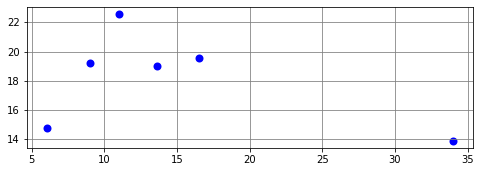

In [37]:
# plotting the linear regression model
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# plt.scatter(bothtrim_df['metabolics_all_avg_mean_x'],
#     bothtrim_df['metabolics_all_avg_mean_y'],
#     c='black')
plt.scatter(y_pred_grfy, y_test_grfy_lg,
    c='blue',
    linewidth=2)
plt.grid(color='grey')

# generate unity line
# unitx = np.linspace(3,10,50)
# unity = unitx
# plt.plot(unitx,unity,'g-')

ax.set_aspect('equal')
# plt.xlim((3,10))
# plt.ylim((3,10))
plt.show()

In [25]:
#######################################################
## single decision tree implementation
X_dt = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_dt = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt,Y_dt,test_size=0.15,random_state=12)
x_train_dt = X_dt[0:30,:]
temp = X_dt[36:-1,:]
x_train_dt = np.append(x_train_dt, temp, axis=0)
y_train_dt = Y_dt[0:30,:]
temp2 = Y_dt[36:-1,:]
y_train_dt = np.append(y_train_dt, temp2, axis=0)
x_test_dt = X_dt[30:36,:]
y_test_dt = Y_dt[30:36,:]

print(x_train_dt.shape)
print(y_train_dt.shape)
print(x_test_dt.shape)
print(y_test_dt.shape)

# x_train = x_train.reshape(-1,)
y_train_dt = y_train_dt.reshape(-1,)
# x_test_dt = x_test_dt.reshape(-1,)
y_test_dt = y_test_dt.reshape(-1,)
# print(x_train_dt.shape)
# print(y_train_dt.shape)

DecisionTreeRegModel = DecisionTreeRegressor(random_state=13)
DecisionTreeRegModel.fit(x_train_dt, y_train_dt)



(34, 1)
(34, 1)
(6, 1)
(6, 1)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=13, splitter='best')

y_test_dt:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_dt:
[9.421522 7.890412 7.890412 4.682754 6.489858 4.682754]

RMSE: 1.078990


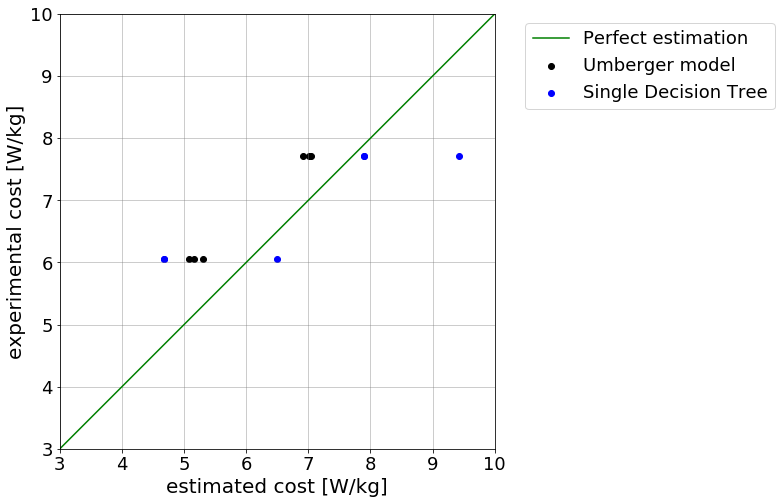

In [26]:
# try some predictions
print('y_test_dt:')
print(y_test_dt)
y_pred_dt = DecisionTreeRegModel.predict(x_test_dt)
print('y_pred_dt:')
print(y_pred_dt)

# error
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print('\nRMSE: %f' % rmse_dt)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_dt,y_test_dt,
    c='black', label='Umberger model')
plt.scatter(y_pred_dt, y_test_dt,
    c='blue', label='Single Decision Tree')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [27]:
########################################################
## random forest implementation

X_rf = bothtrim_df.metabolics_all_avg_mean_x.values.reshape(-1,1)
Y_rf = bothtrim_df.metabolics_all_avg_mean_y.values.reshape(-1,1)

# x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf,Y_rf,test_size=0.15,random_state=12)
x_train_rf = X_rf[0:30,:]
temp = X_rf[36:-1,:]
x_train_rf = np.append(x_train_rf, temp, axis=0)
y_train_rf = Y_rf[0:30,:]
temp2 = Y_rf[36:-1,:]
y_train_rf = np.append(y_train_rf, temp2, axis=0)
x_test_rf = X_rf[30:36,:]
y_test_rf = Y_rf[30:36,:]




# x_train_rf = x_train_rf.reshape(-1,)
y_train_rf = y_train_rf.reshape(-1,)
# x_test_rf = x_test_rf.reshape(-1,)
y_test_rf = y_test_rf.reshape(-1,)
# print(x_train_rf.shape)
# print(y_train_rf.shape)

RandomForestRegModel = RandomForestRegressor(random_state=13)
RandomForestRegModel.fit(x_train_rf, y_train_rf)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=13, verbose=0,
                      warm_start=False)

y_test_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[9.1153    8.196634  7.7904841 5.2248852 5.7670164 5.2248852]

RMSE: 0.786367


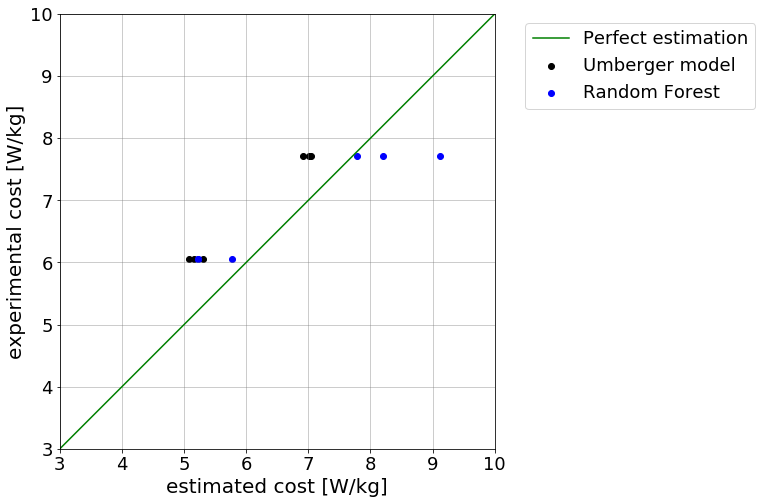

In [28]:
# try some predictions
print('y_test_rf:')
print(y_test_rf)
y_pred_rf = RandomForestRegModel.predict(x_test_rf)
print('y_pred_rf:')
print(y_pred_rf)

# error
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('\nRMSE: %f' % rmse_rf)

# plot the random forest 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(x_test_rf,y_test_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_rf, y_test_rf,
    c='blue', label='Random Forest')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

# Getting X  values with all the umberger components

In [29]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleInversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleInversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df.sort_values(by=['subjectname','condname','trialname'],inplace=True)
muscle_df.drop(['Row'],inplace=True,axis=1)
muscle_df.reset_index(inplace=True,drop=True)
# print(muscle_df)

In [30]:
# figure out how to pair down the experimental to only have these ones
combos = []
for index, row in muscle_df.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    combos.append((subj,cond,trial))
combosunique = set(combos)
# print(combosunique)

idk = pd.merge(expmetcost_df, muscle_df, how='left', indicator=True)
idk2 = idk.reset_index()

indextodrop = []
for index, row in idk2.iterrows():
    subj = row['subjectname']
    cond = row['condname']
    trial = row['trialname']
    if (subj,cond,trial) not in combosunique:
        indextodrop.append(index)

idk3 = idk2.drop(indextodrop)
# print(idk3)
idk4 = idk3.drop(['index','_merge','metabolics_mech_avg','metabolics_basal_avg','metabolics_short_avg','metabolics_act_avg'], axis=1)
# print(idk4)
# sort the dataframe TODO sort the sims one the same way
idk5 = idk4.sort_values(by=['subjectname','condname','trialname'])
idk5.reset_index(inplace=True,drop=True)

exp_df = idk5
# print(exp_df)


## random forest for all umberger inputs

In [45]:
# set up the X and Y
X_multi_rf = muscle_df.iloc[:,0:5].values
# print(X_multi_rf)
Y_multi_rf = exp_df.iloc[:,0].values
# print(Y_multi_rf)

# split into sets
# x_train_multi_rf,x_test_multi_rf,y_train_multi_rf,y_test_multi_rf = train_test_split(X_multi_rf,Y_multi_rf,
#                                                                                      test_size=0.15,
#                                                                                     random_state=12)
x_train_multi_rf = X_multi_rf[0:30,:]
temp = X_multi_rf[36:-1,:]
x_train_multi_rf = np.append(x_train_multi_rf, temp, axis=0)
y_train_multi_rf = Y_multi_rf[0:30]
temp2 = Y_multi_rf[36:-1]
y_train_multi_rf = np.append(y_train_multi_rf, temp2, axis=0)
x_test_multi_rf = X_multi_rf[30:36,:]
y_test_multi_rf = Y_multi_rf[30:36]




# print(X_multi_rf.shape)
# print(Y_multi_rf.shape)

print(x_train_multi_rf.shape)
print(y_train_multi_rf.shape)
print(x_test_multi_rf.shape)
print(y_test_multi_rf.shape)

multiregrf = RandomForestRegressor(random_state=13)
multiregrf.fit(x_train_multi_rf,y_train_multi_rf)
y_pred_multi_rf = multiregrf.predict(x_test_multi_rf)
y_pred_multi_rf_train = multiregrf.predict(x_train_multi_rf)


(34, 5)
(34,)
(6, 5)
(6,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


y_test_multi_rf:
[7.708152 7.708152 7.708152 6.061044 6.061044 6.061044]
y_pred_rf:
[9.421522  8.655967  8.655967  6.3602421 6.1795317 6.3602421]

RMSE baseline: 1.085691

RMSE training: 0.245198

RMSE test: 0.906037


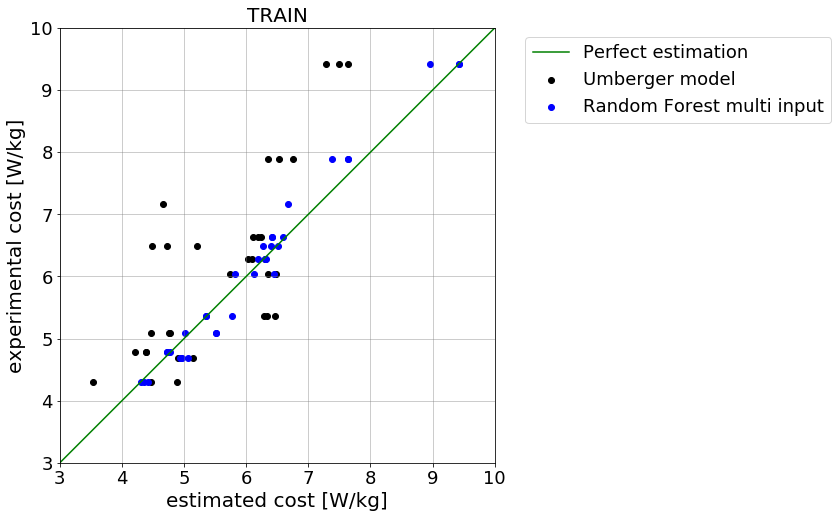

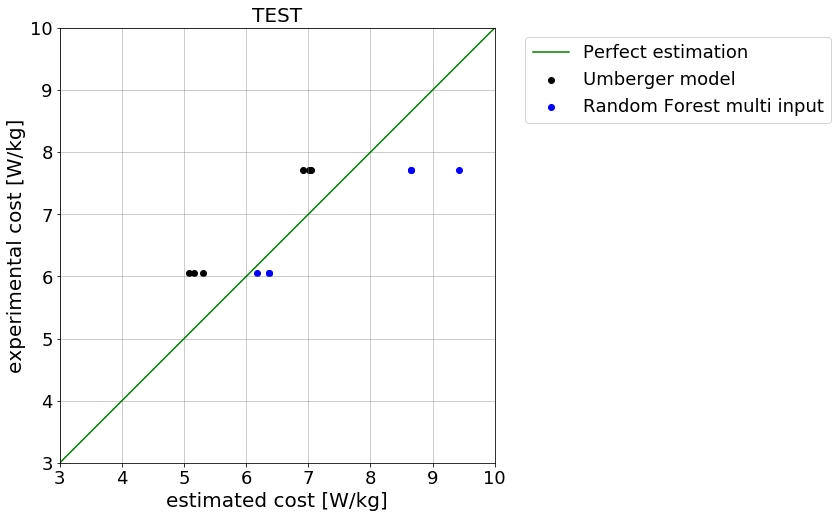

In [46]:
# try some predictions
print('y_test_multi_rf:')
print(y_test_multi_rf)
print('y_pred_rf:')
print(y_pred_multi_rf)

# error
mse_multi_rf_base = mean_squared_error(Y_multi_rf,X_multi_rf[:,0])
rmse_multi_rf_base = np.sqrt(mse_multi_rf_base)
print('\nRMSE baseline: %f' % rmse_multi_rf_base)

mse_multi_rf_train = mean_squared_error(y_train_multi_rf, y_pred_multi_rf_train)
rmse_multi_rf_train = np.sqrt(mse_multi_rf_train)
print('\nRMSE training: %f' % rmse_multi_rf_train)

mse_multi_rf = mean_squared_error(y_test_multi_rf, y_pred_multi_rf)
rmse_multi_rf = np.sqrt(mse_multi_rf)
print('\nRMSE test: %f' % rmse_multi_rf)

# plot the random forest
fig1 = plt.figure(figsize=(8,8))
ax = fig1.add_subplot(111)

plt.scatter(x_train_multi_rf[:,0],y_train_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf_train, y_train_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TRAIN',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



fig2 = plt.figure(figsize=(8,8))
ax = fig2.add_subplot(111)

plt.scatter(x_test_multi_rf[:,0],y_test_multi_rf,
    c='black', label='Umberger model')
plt.scatter(y_pred_multi_rf, y_test_multi_rf,
    c='blue', label='Random Forest multi input')

# generate unity line
unitx = np.linspace(3,10,50)
unity = unitx
plt.plot(unitx,unity,'g-',label='Perfect estimation')

# customize the plot
ax.set_aspect('equal')
plt.grid(color='grey',alpha=0.5)
plt.legend(bbox_to_anchor=(1.05,1),loc='best', fontsize=18)
plt.title('TEST',fontsize=20)
plt.xlim((3,10))
plt.ylim((3,10))
plt.xlabel('estimated cost [W/kg]',fontsize=20)
plt.ylabel('experimental cost [W/kg]',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()